# Feedforward Neural Network with PyTorch on [California Housing Values](https://github.com/ageron/handson-ml/tree/master/datasets/housing) dataset
By [Zahra Taheri](https://github.com/zahta), October 14, 2020

### Import libraries

In [1]:
#For some basic operations
import numpy as np
import pandas as pd
import torch
import torch.nn as nn

#For visualizations
import matplotlib as mpl
import matplotlib.pyplot as plt

# to make this notebook's output identical at every run
#np.random.seed(42)

import warnings
warnings.filterwarnings('ignore')

## Reading the dataset

In [2]:
data=pd.read_csv('housing.csv')
data.shape

(20640, 10)

In [3]:
data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


## Descriptive statistics and data visualizations

In [5]:
#Describe the dataset

data.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [6]:
#Check the no. of unique items in each categorical column

data.select_dtypes('object').nunique()

ocean_proximity    5
dtype: int64

In [7]:
# Percentage of missing data in each column

number_of_columns = data.shape[0]
percentage_of_missing_data = data.isnull().sum()/number_of_columns
print(percentage_of_missing_data)

longitude             0.000000
latitude              0.000000
housing_median_age    0.000000
total_rooms           0.000000
total_bedrooms        0.010029
population            0.000000
households            0.000000
median_income         0.000000
median_house_value    0.000000
ocean_proximity       0.000000
dtype: float64


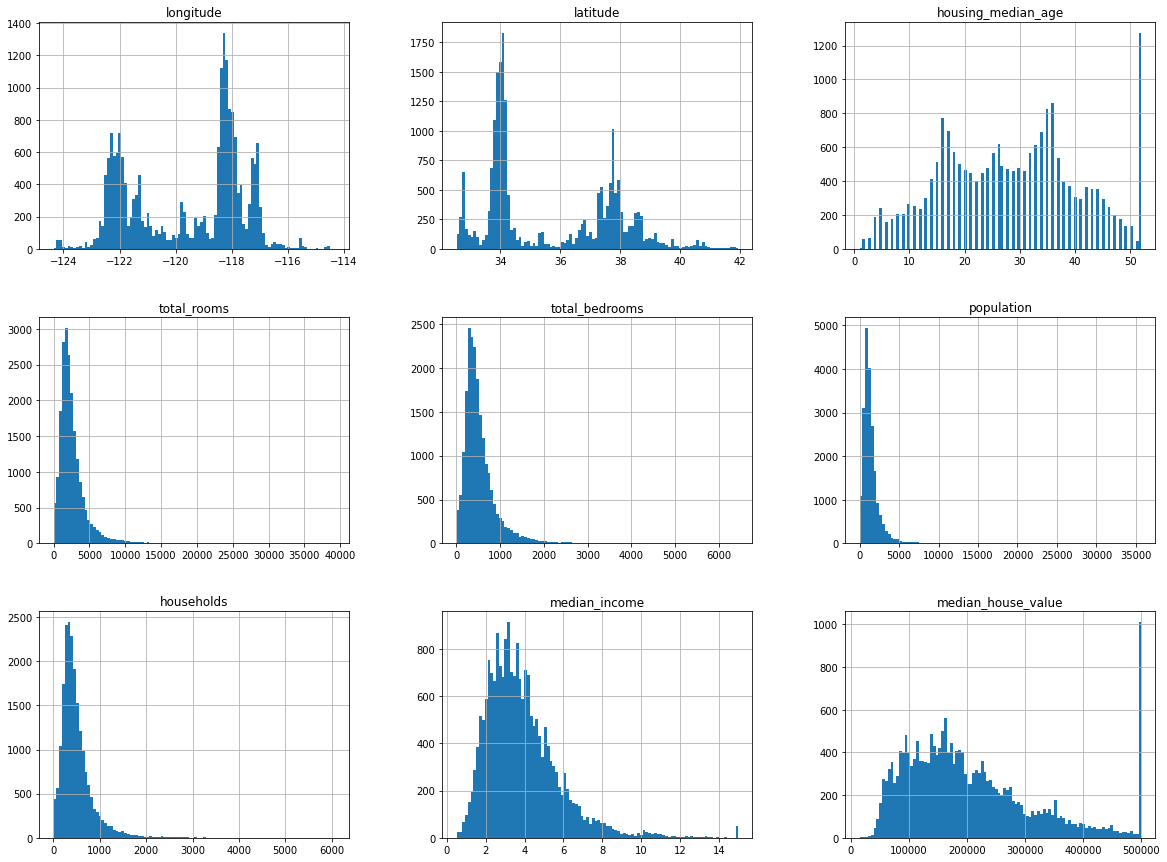

In [8]:
data.hist(bins=100, figsize=(20,15))

plt.show()

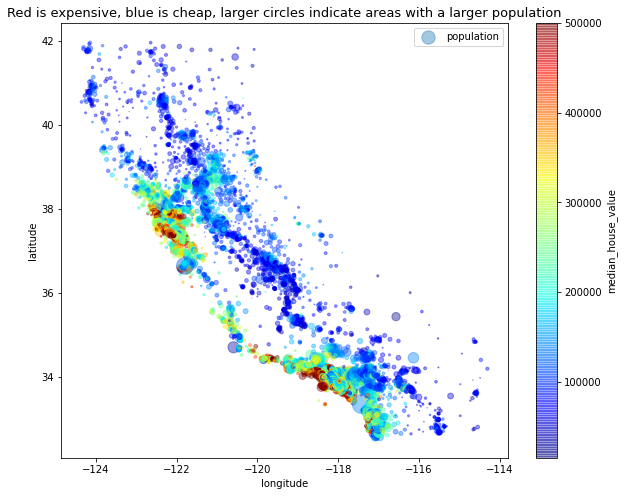

In [9]:
data.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=data["population"]/100, label="population", figsize=(10,8),
    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)
plt.title('Red is expensive, blue is cheap, larger circles indicate areas with a larger population',\
          fontweight = 20, fontsize = 13)
plt.legend()

In [10]:
corr_matrix = data.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64

## Data Cleaning and Preparation

In [13]:
#Fill in missing values with median

from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

In [14]:
#Remove the text attribute because median can only be calculated on numerical attributes:
data_num=data.drop("ocean_proximity", axis=1)

In [15]:
imputer.fit(data_num)
imputer.statistics_

array([-1.1849e+02,  3.4260e+01,  2.9000e+01,  2.1270e+03,  4.3500e+02,
        1.1660e+03,  4.0900e+02,  3.5348e+00,  1.7970e+05])

In [16]:
X = imputer.transform(data_num)
data_num_clean = pd.DataFrame(X, columns=data_num.columns,index=data_num.index)
data_num_clean.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0


In [17]:
data_num_clean["rooms_per_household"] = data_num_clean["total_rooms"]/data_num_clean["households"]
data_num_clean["bedrooms_per_room"] = data_num_clean["total_bedrooms"]/data_num_clean["total_rooms"]
data_num_clean["population_per_household"]=data_num_clean["population"]/data_num_clean["households"]

In [18]:
#Preprocess the categorical input feature, `ocean_proximity`:
data_cat = data[["ocean_proximity"]]

In [19]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
data_cat_encoded = ordinal_encoder.fit_transform(data_cat)

In [21]:
data_num_clean["ocean_proximity"]=data_cat_encoded
data_clean=data_num_clean
data_clean.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_household,bedrooms_per_room,population_per_household,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,6.984127,0.146591,2.555556,3.0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,6.238137,0.155797,2.109842,3.0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,8.288136,0.129516,2.802260,3.0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,5.817352,0.184458,2.547945,3.0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,6.281853,0.172096,2.181467,3.0


In [22]:
housing_labels = data_clean["median_house_value"]
data_clean = data_clean.drop("median_house_value", axis=1)
data_clean["median_house_value"] = housing_labels
data_clean

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_household,bedrooms_per_room,population_per_household,ocean_proximity,median_house_value
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,6.984127,0.146591,2.555556,3.0,452600.0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,6.238137,0.155797,2.109842,3.0,358500.0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,8.288136,0.129516,2.802260,3.0,352100.0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,5.817352,0.184458,2.547945,3.0,341300.0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,6.281853,0.172096,2.181467,3.0,342200.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,5.045455,0.224625,2.560606,1.0,78100.0
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,6.114035,0.215208,3.122807,1.0,77100.0
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,5.205543,0.215173,2.325635,1.0,92300.0
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,5.329513,0.219892,2.123209,1.0,84700.0


In [23]:
from sklearn import preprocessing

minmax_scale = preprocessing.MinMaxScaler()
X_scaled = minmax_scale.fit_transform(data_clean)
X_scaled.shape

(20640, 13)

In [24]:
#Splitting the dependent and independent variables

X = X_scaled[:,:-1]
y = X_scaled[:,-1]

print(X.shape)
print(y.shape)

(20640, 12)
(20640,)


In [25]:
#Splitting the dataset into training and test sets

from sklearn.model_selection import train_test_split

train_data, test_data, train_labels, test_labels = train_test_split(X, y, test_size = 0.2, random_state = 42)

print(train_data.shape)
print(train_labels.shape)
print(test_data.shape)

(16512, 12)
(16512,)
(4128, 12)


In [26]:
train_data = train_data
test_data = test_data
train_labels = train_labels.reshape(-1,1)
test_labels = test_labels.reshape(-1,1)

In [27]:
train_labels

array([[0.18144461],
       [0.75690616],
       [0.32494918],
       ...,
       [0.42701061],
       [0.55360803],
       [0.63917468]])

## Preparation of the dataset for PyTorch

In [30]:
from torch.utils.data import TensorDataset, DataLoader

tensor_x = torch.tensor(train_data, dtype=torch.float).cuda() # transform to torch tensor
tensor_x2 = torch.tensor(test_data, dtype=torch.float).cuda() 

In [31]:
tensor_y = torch.tensor(train_labels, dtype=torch.float).cuda()
tensor_y2 = torch.tensor(test_labels, dtype=torch.float).cuda()

In [32]:
train_dataset = TensorDataset(tensor_x, tensor_y) # create your dataset
test_dataset = TensorDataset(tensor_x2,tensor_y2)

In [33]:
# Normalizing the data

#print(tensor_x,tensor_x2)

#mean = torch.mean(tensor_x)
#std = torch.std(tensor_x)

#tensor_x = (tensor_x - mean) / std
#tensor_x2 = (tensor_x2 - mean) / std

## Building Feedforward Neural Networks with PyTorch

In [34]:
# import libraries

import torch
import torch.nn as nn
from torch.autograd import Variable
from torchsummary import summary

### Model A: 3 Hidden Layers Feedforward Neural Network

### Create model class

In [35]:
batch_size = 128
n_iters = 10000
num_epochs = n_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)

77


In [36]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # create your dataloader

test_loader = DataLoader(test_dataset, batch_size=batch_size,  shuffle=False)

In [37]:
class FNN(nn.Module):
    def __init__(self, input_dim, hidden_dim1,hidden_dim2,hidden_dim3, output_dim):
        super(FNN, self).__init__()
        
        self.linear1 = nn.Linear(input_dim, hidden_dim1)
        self.linear2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.linear3 = nn.Linear(hidden_dim2, hidden_dim3)
        self.linear4 = nn.Linear(hidden_dim3, output_dim)
        
    def forward(self, x):
        out = self.linear1(x).clamp(min=0)
        out = self.linear2(out).clamp(min=0)
        out = self.linear3(out).clamp(min=0)
        out = self.linear4(out)
        return out

In [38]:
input_dim = tensor_x.shape[1]
output_dim = 1
hidden_dim1 = 500
hidden_dim2 = 1000
hidden_dim3 = 200

In [39]:
model = FNN(input_dim, hidden_dim1,hidden_dim2,hidden_dim3, output_dim)

#######################
#  USE GPU FOR MODEL  #
#######################
if torch.cuda.is_available():
    model.cuda()


In [40]:
summary(model, (1,tensor_x.shape[1]))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 500]           6,500
            Linear-2              [-1, 1, 1000]         501,000
            Linear-3               [-1, 1, 200]         200,200
            Linear-4                 [-1, 1, 1]             201
Total params: 707,901
Trainable params: 707,901
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 2.70
Estimated Total Size (MB): 2.71
----------------------------------------------------------------


In [41]:
criterion = nn.MSELoss(reduction='sum')

learning_rate = 0.001
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [42]:
# Train the model

train_loss = []

iter = 0
for epoch in range(num_epochs):
    
    '''
    One iteration
    '''
    for i, (X, labels) in enumerate(train_loader):
        #######################
        #  USE GPU FOR MODEL  #
        #######################
        if torch.cuda.is_available():
            X = Variable(X.cuda())
            labels = Variable(labels.cuda())
        else:
            X = Variable(X)
            labels = Variable(labels)
        
        # Forward pass to get output/logits
        outputs = model(X)
        
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
        
        # Calculate Loss:
        loss = criterion(outputs, labels)
                
        '''
        Save loss to draw loss curve
        '''
        train_loss.append(loss)
        ''''''

        # Getting gradients w.r.t. parameters
        loss.backward()
        
        # Updating parameters
        optimizer.step()
        ''''''
        
        iter += 1
    
        # Testing the model
        if iter % 500 == 0:
            # Iterate through test dataset
            for X, labels in test_loader:
                #######################
                #  USE GPU FOR MODEL  #
                #######################
                if torch.cuda.is_available():
                    X = Variable(X.cuda())
                else:
                    X = Variable(X)    
                    
                # Forward pass only to get logits/output
                outputs = model(X)
                
                # Calculate Loss:
                loss_t = criterion(outputs, labels)
                
            # Print Loss
            print('Iteration: {}. Training Loss: {}. Test Loss: {}'.format(iter, loss.data, loss_t.data))
            

Iteration: 500. Training Loss: 3.2322542667388916. Test Loss: 0.3689999580383301
Iteration: 1000. Training Loss: 2.230991840362549. Test Loss: 0.28060686588287354
Iteration: 1500. Training Loss: 2.7168712615966797. Test Loss: 0.2774960398674011
Iteration: 2000. Training Loss: 1.9698190689086914. Test Loss: 0.42408788204193115
Iteration: 2500. Training Loss: 2.865222454071045. Test Loss: 0.4667242765426636
Iteration: 3000. Training Loss: 2.730923652648926. Test Loss: 0.2627788782119751
Iteration: 3500. Training Loss: 2.174466609954834. Test Loss: 0.3203355669975281
Iteration: 4000. Training Loss: 2.105297565460205. Test Loss: 0.280778706073761
Iteration: 4500. Training Loss: 2.5902342796325684. Test Loss: 0.2748432755470276
Iteration: 5000. Training Loss: 2.144698143005371. Test Loss: 0.4639221429824829
Iteration: 5500. Training Loss: 2.5857996940612793. Test Loss: 0.5262027382850647
Iteration: 6000. Training Loss: 3.4844584465026855. Test Loss: 1.0604453086853027
Iteration: 6500. Train

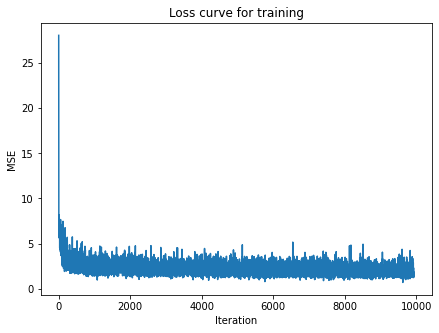

In [43]:
#Plot the loss curve

plt.figure(figsize=(7,5))
plt.plot(range(len(train_loss)), train_loss)
plt.xlabel("Iteration")
plt.ylabel("MSE")
plt.title("Loss curve for training")
plt.show()

In [44]:
save_model = True
if save_model is True:
    torch.save(model.state_dict(), 'housing_FNN_pytorch_A.pkl')# only save parameters

### Model B: 3 Hidden Layers Feedforward Neural Network (ReLU activation)

### Create model class

In [45]:
batch_size = 16
n_iters = 21000
num_epochs = n_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)

20


In [46]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # create your dataloader

test_loader = DataLoader(test_dataset, batch_size=batch_size,  shuffle=False)

In [47]:
class FNN(nn.Module):
    def __init__(self, input_dim, hidden_dim1,hidden_dim2,hidden_dim3, output_dim):
        super(FNN, self).__init__()
        
        self.linear1 = nn.Linear(input_dim, hidden_dim1)
        self.relu1 = nn.ReLU()
        self.linear2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.relu2 = nn.ReLU()
        self.linear3 = nn.Linear(hidden_dim2, hidden_dim3)
        self.relu3 = nn.ReLU()
        self.linear4 = nn.Linear(hidden_dim3, output_dim)
        
    def forward(self, x):
        out = self.linear1(x)
        out = self.relu1(out)
        out = self.linear2(out)
        out = self.relu2(out)
        out = self.linear3(out)
        out = self.relu3(out)
        out = self.linear4(out)
        return out

In [48]:
input_dim = tensor_x.shape[1]
output_dim = 1
hidden_dim1 = 500
hidden_dim2 = 1000
hidden_dim3 = 200

In [49]:
model = FNN(input_dim, hidden_dim1,hidden_dim2,hidden_dim3, output_dim)

#######################
#  USE GPU FOR MODEL  #
#######################
if torch.cuda.is_available():
    model.cuda()


In [50]:
summary(model, (1,tensor_x.shape[1]))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 500]           6,500
              ReLU-2               [-1, 1, 500]               0
            Linear-3              [-1, 1, 1000]         501,000
              ReLU-4              [-1, 1, 1000]               0
            Linear-5               [-1, 1, 200]         200,200
              ReLU-6               [-1, 1, 200]               0
            Linear-7                 [-1, 1, 1]             201
Total params: 707,901
Trainable params: 707,901
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.03
Params size (MB): 2.70
Estimated Total Size (MB): 2.73
----------------------------------------------------------------


In [51]:
criterion = nn.MSELoss(reduction='sum')

learning_rate = 0.0001
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [52]:
# Train the model

train_loss = []

iter = 0
for epoch in range(num_epochs):
    
    '''
    One iteration
    '''
    for i, (X, labels) in enumerate(train_loader):
        #######################
        #  USE GPU FOR MODEL  #
        #######################
        if torch.cuda.is_available():
            X = Variable(X.cuda())
            labels = Variable(labels.cuda())
        else:
            X = Variable(X)
            labels = Variable(labels)
        
        # Forward pass to get output/logits
        outputs = model(X)
        
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
        
        # Calculate Loss:
        loss = criterion(outputs, labels)
                
        '''
        Save loss to draw loss curve
        '''
        train_loss.append(loss)
        ''''''

        # Getting gradients w.r.t. parameters
        loss.backward()
        
        # Updating parameters
        optimizer.step()
        ''''''
        
        iter += 1
    
        # Testing the model
        if iter % 500 == 0:
            # Iterate through test dataset
            for X, labels in test_loader:
                #######################
                #  USE GPU FOR MODEL  #
                #######################
                if torch.cuda.is_available():
                    X = Variable(X.cuda())
                else:
                    X = Variable(X)    
                    
                # Forward pass only to get logits/output
                outputs = model(X)
                
                # Calculate Loss:
                loss_t = criterion(outputs, labels)
                
            # Print Loss
            print('Iteration: {}. Training Loss: {}. Test Loss: {}'.format(iter, loss.data, loss_t.data))
            

Iteration: 500. Training Loss: 0.976995587348938. Test Loss: 1.4703352451324463
Iteration: 1000. Training Loss: 0.590218722820282. Test Loss: 1.4042195081710815
Iteration: 1500. Training Loss: 1.0419752597808838. Test Loss: 1.3420716524124146
Iteration: 2000. Training Loss: 0.6847468614578247. Test Loss: 1.3044798374176025
Iteration: 2500. Training Loss: 0.9113125205039978. Test Loss: 1.246578335762024
Iteration: 3000. Training Loss: 0.5212317109107971. Test Loss: 1.196395993232727
Iteration: 3500. Training Loss: 1.0826783180236816. Test Loss: 1.135572910308838
Iteration: 4000. Training Loss: 0.8929678797721863. Test Loss: 1.0886212587356567
Iteration: 4500. Training Loss: 0.44212716817855835. Test Loss: 1.0216152667999268
Iteration: 5000. Training Loss: 0.6011855602264404. Test Loss: 0.9586695432662964
Iteration: 5500. Training Loss: 0.5937200784683228. Test Loss: 0.899177074432373
Iteration: 6000. Training Loss: 1.1401714086532593. Test Loss: 0.8258193135261536
Iteration: 6500. Train

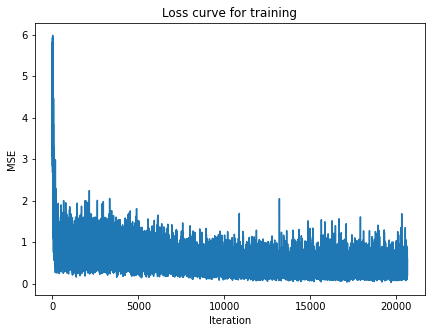

In [53]:
#Plot the loss curve

plt.figure(figsize=(7,5))
plt.plot(range(len(train_loss)), train_loss)
plt.xlabel("Iteration")
plt.ylabel("MSE")
plt.title("Loss curve for training")
plt.show()


In [54]:
save_model = True
if save_model is True:
    torch.save(model.state_dict(), 'housing_FNN_pytorch_B.pkl')# only save parameters

### Model C: 3 Hidden Layers Feedforward Neural Network (LeakyReLU activation)

### Create model class

In [55]:
batch_size = 16
n_iters = 40000
num_epochs = n_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)

38


In [56]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # create your dataloader

test_loader = DataLoader(test_dataset, batch_size=batch_size,  shuffle=False)

In [57]:
class FNN(nn.Module):
    def __init__(self, input_dim, hidden_dim1,hidden_dim2,hidden_dim3, output_dim):
        super(FNN, self).__init__()
        
        self.linear1 = nn.Linear(input_dim, hidden_dim1)
        self.relu1 = nn.LeakyReLU()
        self.linear2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.relu2 = nn.LeakyReLU()
        self.linear3 = nn.Linear(hidden_dim2, hidden_dim3)
        self.relu3 = nn.LeakyReLU()
        self.linear4 = nn.Linear(hidden_dim3, output_dim)
        
    def forward(self, x):
        out = self.linear1(x)
        out = self.relu1(out)
        out = self.linear2(out)
        out = self.relu2(out)
        out = self.linear3(out)
        out = self.relu3(out)
        out = self.linear4(out)
        return out

In [58]:
input_dim = tensor_x.shape[1]
output_dim = 1
hidden_dim1 = 500
hidden_dim2 = 1000
hidden_dim3 = 100

In [59]:
model = FNN(input_dim, hidden_dim1,hidden_dim2,hidden_dim3, output_dim)

#######################
#  USE GPU FOR MODEL  #
#######################
if torch.cuda.is_available():
    model.cuda()


In [60]:
summary(model, (1,tensor_x.shape[1]))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 500]           6,500
         LeakyReLU-2               [-1, 1, 500]               0
            Linear-3              [-1, 1, 1000]         501,000
         LeakyReLU-4              [-1, 1, 1000]               0
            Linear-5               [-1, 1, 100]         100,100
         LeakyReLU-6               [-1, 1, 100]               0
            Linear-7                 [-1, 1, 1]             101
Total params: 607,701
Trainable params: 607,701
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 2.32
Estimated Total Size (MB): 2.34
----------------------------------------------------------------


In [61]:
criterion = nn.MSELoss(reduction='sum')

learning_rate = 0.0001
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [62]:
# Train the model

train_loss = []

iter = 0
for epoch in range(num_epochs):
    
    '''
    One iteration
    '''
    for i, (X, labels) in enumerate(train_loader):
        #######################
        #  USE GPU FOR MODEL  #
        #######################
        if torch.cuda.is_available():
            X = Variable(X.cuda())
            labels = Variable(labels.cuda())
        else:
            X = Variable(X)
            labels = Variable(labels)
        
        # Forward pass to get output/logits
        outputs = model(X)
        
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
        
        # Calculate Loss:
        loss = criterion(outputs, labels)
                
        '''
        Save loss to draw loss curve
        '''
        train_loss.append(loss)
        ''''''

        # Getting gradients w.r.t. parameters
        loss.backward()
        
        # Updating parameters
        optimizer.step()
        ''''''
        
        iter += 1
    
        # Testing the model
        if iter % 500 == 0:
            # Iterate through test dataset
            for X, labels in test_loader:
                #######################
                #  USE GPU FOR MODEL  #
                #######################
                if torch.cuda.is_available():
                    X = Variable(X.cuda())
                else:
                    X = Variable(X)    
                    
                # Forward pass only to get logits/output
                outputs = model(X)
                
                # Calculate Loss:
                loss_t = criterion(outputs, labels)
                
            # Print Loss
            print('Iteration: {}. Training Loss: {}. Test Loss: {}'.format(iter, loss.data, loss_t.data))
            

Iteration: 500. Training Loss: 1.2371065616607666. Test Loss: 1.4756749868392944
Iteration: 1000. Training Loss: 0.6935588717460632. Test Loss: 1.4109476804733276
Iteration: 1500. Training Loss: 0.8972057104110718. Test Loss: 1.3445130586624146
Iteration: 2000. Training Loss: 1.3363384008407593. Test Loss: 1.2909979820251465
Iteration: 2500. Training Loss: 0.6659228801727295. Test Loss: 1.2338151931762695
Iteration: 3000. Training Loss: 0.806613564491272. Test Loss: 1.1774530410766602
Iteration: 3500. Training Loss: 0.6670856475830078. Test Loss: 1.1273945569992065
Iteration: 4000. Training Loss: 0.38364580273628235. Test Loss: 1.060425043106079
Iteration: 4500. Training Loss: 0.6632309556007385. Test Loss: 0.9909414649009705
Iteration: 5000. Training Loss: 0.43585312366485596. Test Loss: 0.9260097742080688
Iteration: 5500. Training Loss: 0.4428751766681671. Test Loss: 0.8561998009681702
Iteration: 6000. Training Loss: 0.40414780378341675. Test Loss: 0.7829056978225708
Iteration: 6500.

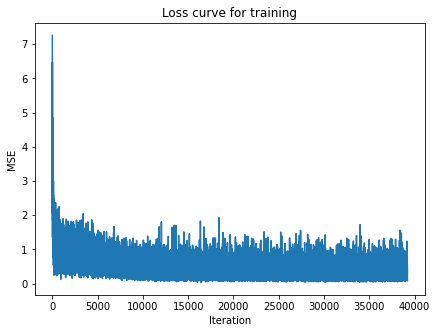

In [63]:
#Plot the loss curve

plt.figure(figsize=(7,5))
plt.plot(range(len(train_loss)), train_loss)
plt.xlabel("Iteration")
plt.ylabel("MSE")
plt.title("Loss curve for training")
plt.show()

In [64]:
save_model = True
if save_model is True:
    torch.save(model.state_dict(), 'housing_FNN_pytorch_C.pkl')# only save parameters

### Model D: 5 Hidden Layers Feedforward Neural Network

### Create model class

In [65]:
batch_size = 16
n_iters = 40000
num_epochs = n_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)

38


In [66]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # create your dataloader

test_loader = DataLoader(test_dataset, batch_size=batch_size,  shuffle=False)

In [67]:
class FNN(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, hidden_dim3, hidden_dim4, hidden_dim5, output_dim):
        super(FNN, self).__init__()
        
        self.linear1 = nn.Linear(input_dim, hidden_dim1)
        self.relu1 = nn.ReLU()
        self.linear2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.relu2 = nn.ReLU()
        self.linear3 = nn.Linear(hidden_dim2, hidden_dim3)
        self.relu3 = nn.ReLU()
        self.linear4 = nn.Linear(hidden_dim3, hidden_dim4)
        self.relu4 = nn.ReLU()
        self.linear5 = nn.Linear(hidden_dim4, hidden_dim5)
        self.relu5 = nn.ReLU()
        self.linear6 = nn.Linear(hidden_dim5, output_dim)
        
    def forward(self, x):
        out = self.linear1(x)
        out = self.relu1(out)
        out = self.linear2(out)
        out = self.relu2(out)
        out = self.linear3(out)
        out = self.relu3(out)
        out = self.linear4(out)
        out = self.relu4(out)
        out = self.linear5(out)
        out = self.relu5(out)
        out = self.linear6(out)
        return out
    

In [68]:
input_dim = tensor_x.shape[1]
output_dim = 1
hidden_dim1 = 500
hidden_dim2 = 1000
hidden_dim3 = 200
hidden_dim4 = 100
hidden_dim5 = 10

In [69]:
model = FNN(input_dim, hidden_dim1,hidden_dim2,hidden_dim3,hidden_dim4,hidden_dim5, output_dim)

#######################
#  USE GPU FOR MODEL  #
#######################
if torch.cuda.is_available():
    model.cuda()


In [70]:
summary(model, (1,tensor_x.shape[1]))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 500]           6,500
              ReLU-2               [-1, 1, 500]               0
            Linear-3              [-1, 1, 1000]         501,000
              ReLU-4              [-1, 1, 1000]               0
            Linear-5               [-1, 1, 200]         200,200
              ReLU-6               [-1, 1, 200]               0
            Linear-7               [-1, 1, 100]          20,100
              ReLU-8               [-1, 1, 100]               0
            Linear-9                [-1, 1, 10]           1,010
             ReLU-10                [-1, 1, 10]               0
           Linear-11                 [-1, 1, 1]              11
Total params: 728,821
Trainable params: 728,821
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

In [71]:
criterion = nn.MSELoss(reduction='sum')

learning_rate = 0.001
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [72]:
# Train the model

train_loss = []

iter = 0
for epoch in range(num_epochs):
    
    '''
    One iteration
    '''
    for i, (X, labels) in enumerate(train_loader):
        #######################
        #  USE GPU FOR MODEL  #
        #######################
        if torch.cuda.is_available():
            X = Variable(X.cuda())
            labels = Variable(labels.cuda())
        else:
            X = Variable(X)
            labels = Variable(labels)
        
        # Forward pass to get output/logits
        outputs = model(X)
        
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
        
        # Calculate Loss:
        loss = criterion(outputs, labels)
                
        '''
        Save loss to draw loss curve
        '''
        train_loss.append(loss)
        ''''''

        # Getting gradients w.r.t. parameters
        loss.backward()
        
        # Updating parameters
        optimizer.step()
        ''''''
        
        iter += 1
    
        # Testing the model
        if iter % 500 == 0:
            # Iterate through test dataset
            for X, labels in test_loader:
                #######################
                #  USE GPU FOR MODEL  #
                #######################
                if torch.cuda.is_available():
                    X = Variable(X.cuda())
                else:
                    X = Variable(X)    
                    
                # Forward pass only to get logits/output
                outputs = model(X)
                
                # Calculate Loss:
                loss_t = criterion(outputs, labels)
                
            # Print Loss
            print('Iteration: {}. Training Loss: {}. Test Loss: {}'.format(iter, loss.data, loss_t.data))
            

Iteration: 500. Training Loss: 0.9887386560440063. Test Loss: 1.500828742980957
Iteration: 1000. Training Loss: 1.0244048833847046. Test Loss: 1.483139157295227
Iteration: 1500. Training Loss: 0.7902580499649048. Test Loss: 1.4552035331726074
Iteration: 2000. Training Loss: 1.106745958328247. Test Loss: 1.3982053995132446
Iteration: 2500. Training Loss: 0.7531806230545044. Test Loss: 1.2448413372039795
Iteration: 3000. Training Loss: 0.4115296006202698. Test Loss: 0.833008885383606
Iteration: 3500. Training Loss: 0.48819711804389954. Test Loss: 0.28706875443458557
Iteration: 4000. Training Loss: 0.3457321524620056. Test Loss: 0.1883053332567215
Iteration: 4500. Training Loss: 0.18850202858448029. Test Loss: 0.14362406730651855
Iteration: 5000. Training Loss: 0.3562203645706177. Test Loss: 0.16822116076946259
Iteration: 5500. Training Loss: 0.5992488861083984. Test Loss: 0.22454920411109924
Iteration: 6000. Training Loss: 0.4018903374671936. Test Loss: 0.1464638113975525
Iteration: 6500

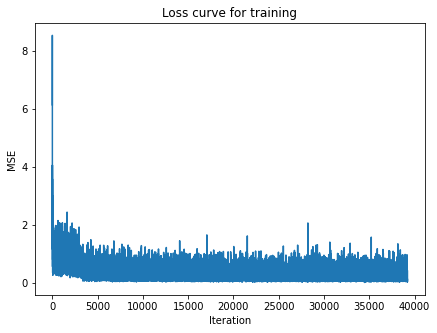

In [73]:
#Plot the loss curve

plt.figure(figsize=(7,5))
plt.plot(range(len(train_loss)), train_loss)
plt.xlabel("Iteration")
plt.ylabel("MSE")
plt.title("Loss curve for training")
plt.show()

In [74]:
save_model = True
if save_model is True:
    torch.save(model.state_dict(), 'housing_FNN_pytorch_D.pkl')# only save parameters